# Two approaches in cell typing of MERFISH data
- Cell typing by using the mean expression per cluster

In [8]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 8
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=100, facecolor='white', figsize=(5,5), frameon=False)

## Using mean exp per cluster

In [2]:
# read the MERFISH data
adata_sp = sc.read_h5ad('./Results_h5ad/04_MERFISH_prep_co1.h5ad')

In [3]:
# read the marker table identified from from scRNA-seq
class_mk = pd.read_excel('./Results_table/03_scRNA_10x_AIBA_class_mk.xlsx', index_col=0)

In [4]:
# only keep gene names that are in the MERFISH data
class_mk = class_mk[class_mk.names.isin(adata_sp.var_names)].reset_index(drop=True)

In [5]:
# keep the top 30 genes for each cell type
top30_mk = class_mk.groupby('names').head(30)
top30_mk.index = top30_mk.names

In [8]:
# Get average expression of gene per cluster from MERFISH data
ser_counts = adata_sp.obs["leiden_sub"].value_counts()
ser_counts.name = "cell counts"
meta_leiden = pd.DataFrame(ser_counts)

cat_name = "leiden_sub"
sig_leiden = pd.DataFrame(
    columns=adata_sp.var_names, index=adata_sp.obs[cat_name].cat.categories
)
for clust in adata_sp.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = adata_sp[adata_sp.obs[cat_name].isin([clust]), :].layers['norm'].mean(0)
    
sig_leiden = sig_leiden.transpose()
sig_leiden.columns = sig_leiden.columns.tolist()
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden[cat_name] = pd.Series(
    meta_leiden.index.tolist(), index=meta_leiden.index.tolist()
)

In [10]:
# create a dataframe corresponding to the top 30 genes for each cell type
meta_gene = pd.DataFrame(index=top30_mk.names.tolist())
meta_gene["info"] = ""
meta_gene["Markers"] = top30_mk["group"]

In [123]:
# assign cell type to each cluster based on the top 100 genes in each cluster that intersect with the top 30 genes for each cell type
# cell types with the most intersecting genes are assigned to the cluster
meta_leiden["Cell_Type"] = 'N.A.'
for inst_cluster in sig_leiden.columns.tolist():
    top_genes = (
        sig_leiden[inst_cluster]
        .sort_values(ascending=False)
        .index.tolist()[:100]
    )
    inst_ser = meta_gene.loc[meta_gene.index.isin(top_genes), "Markers"]
    inst_ser = inst_ser[inst_ser != "N.A."]
    ser_counts = inst_ser.value_counts()
    max_count = ser_counts.max()

    max_cat = "_".join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
    max_cat = max_cat.replace(" marker", "").replace(" ", "-")

    print(inst_cluster, max_cat)
    meta_leiden.loc[inst_cluster, "Cell_Type"] = max_cat

0 Astro-Epen
1 Vascular
2 CNU-LGE-GABA
3 OPC-Oligo
4 IT-ET-Glut
5 IT-ET-Glut
6 CNU-LGE-GABA
7 CNU-HYa-GABA_CNU-HYa-Glut
8 OPC-Oligo
9 Immune
10 NP-CT-L6b-Glut
11 OPC-Oligo
12 IT-ET-Glut
13 Vascular
14 Astro-Epen
15,0 LSX-Otx2-Gaba
15,1 LSX-Prdm12-Slit2-Gaba
15,2 LSX-Prdm12-Zeb2-Gaba
15,3 LSX-Prdm12-Slit2-Gaba
15,4 LSX-Prdm12-Slit2-Gaba
15,5 LSX-Prdm12-Zeb2-Gaba
15,6 LSX-Prdm12-Slit2-Gaba
15,7 LSX-Prdm12-Zeb2-Gaba
15,8 LSX-Sall3-Pax6-Gaba
15,9 LSX-Prdm12-Slit2-Gaba
15,10 LSX-Nkx2-1-Gaba
15,11 LSX-Nkx2-1-Gaba
15,12 LSX-Prdm12-Zeb2-Gaba
16 CTX-MGE-GABA
17 IT-ET-Glut
18 Vascular
19 CNU-LGE-GABA
20 CNU-MGE-GABA
21 CTX-CGE-GABA
22 IT-ET-Glut
23 Astro-Epen
24 CNU-HYa-Glut
25 NP-CT-L6b-Glut
26 CNU-HYa-Glut
27 NP-CT-L6b-Glut
28 CNU-LGE-GABA
29 IT-ET-Glut
30 OB-IMN-GABA
31 Astro-Epen
32 CNU-HYa-Glut
33 CNU-MGE-GABA
34 HY-GABA


In [126]:
ct_dict = meta_leiden.Cell_Type.to_dict()

In [130]:
adata_sp.obs['CellType'] = adata_sp.obs.leiden_sub.map(ct_dict)

In [137]:
lsx_grp = adata_sp.obs.CellType[adata_sp.obs.CellType.str.contains('LSX')].unique().tolist()

In [138]:
lsx_grp

['LSX-Prdm12-Zeb2-Gaba',
 'LSX-Prdm12-Slit2-Gaba',
 'LSX-Otx2-Gaba',
 'LSX-Nkx2-1-Gaba',
 'LSX-Sall3-Pax6-Gaba']

/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


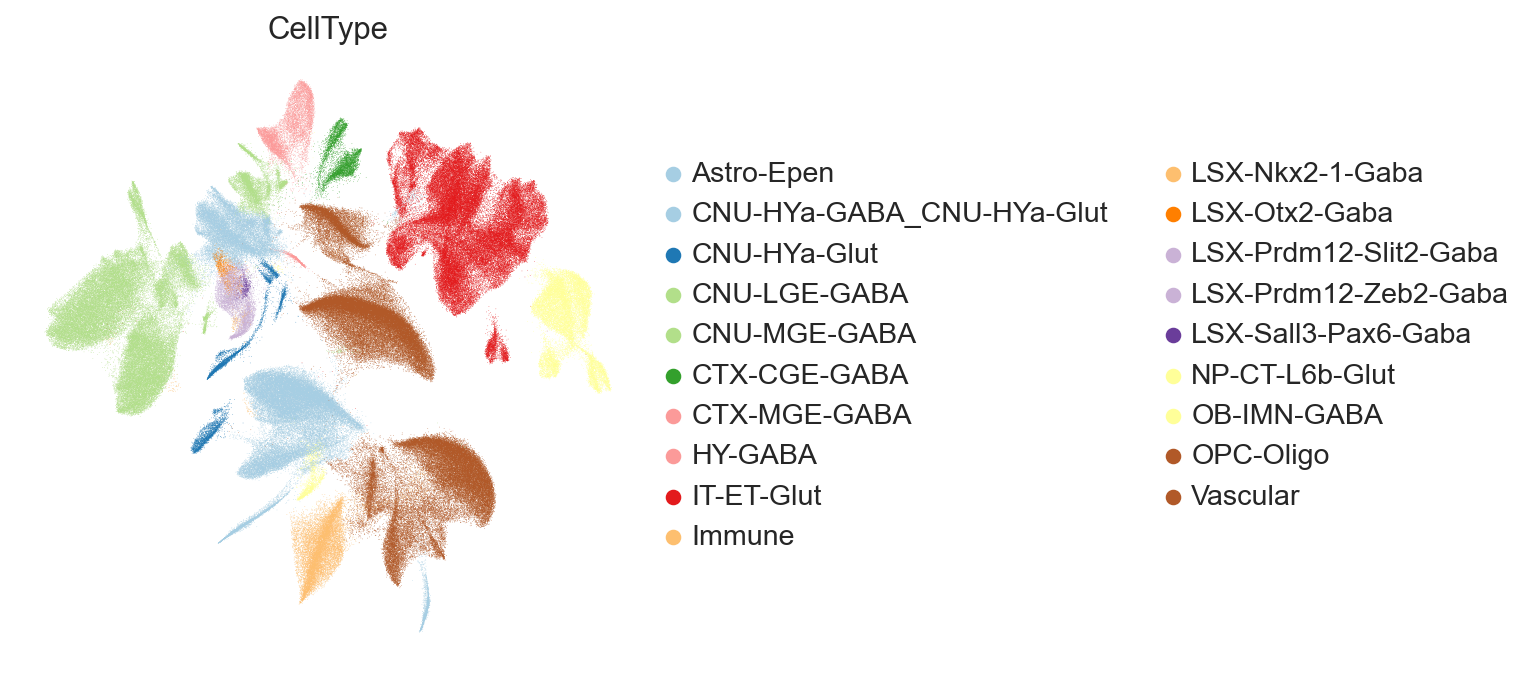

In [162]:
sc.pl.umap(adata_sp, color=['CellType'], frameon=False, ncols=1, palette='Paired')

co1_slice22


/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

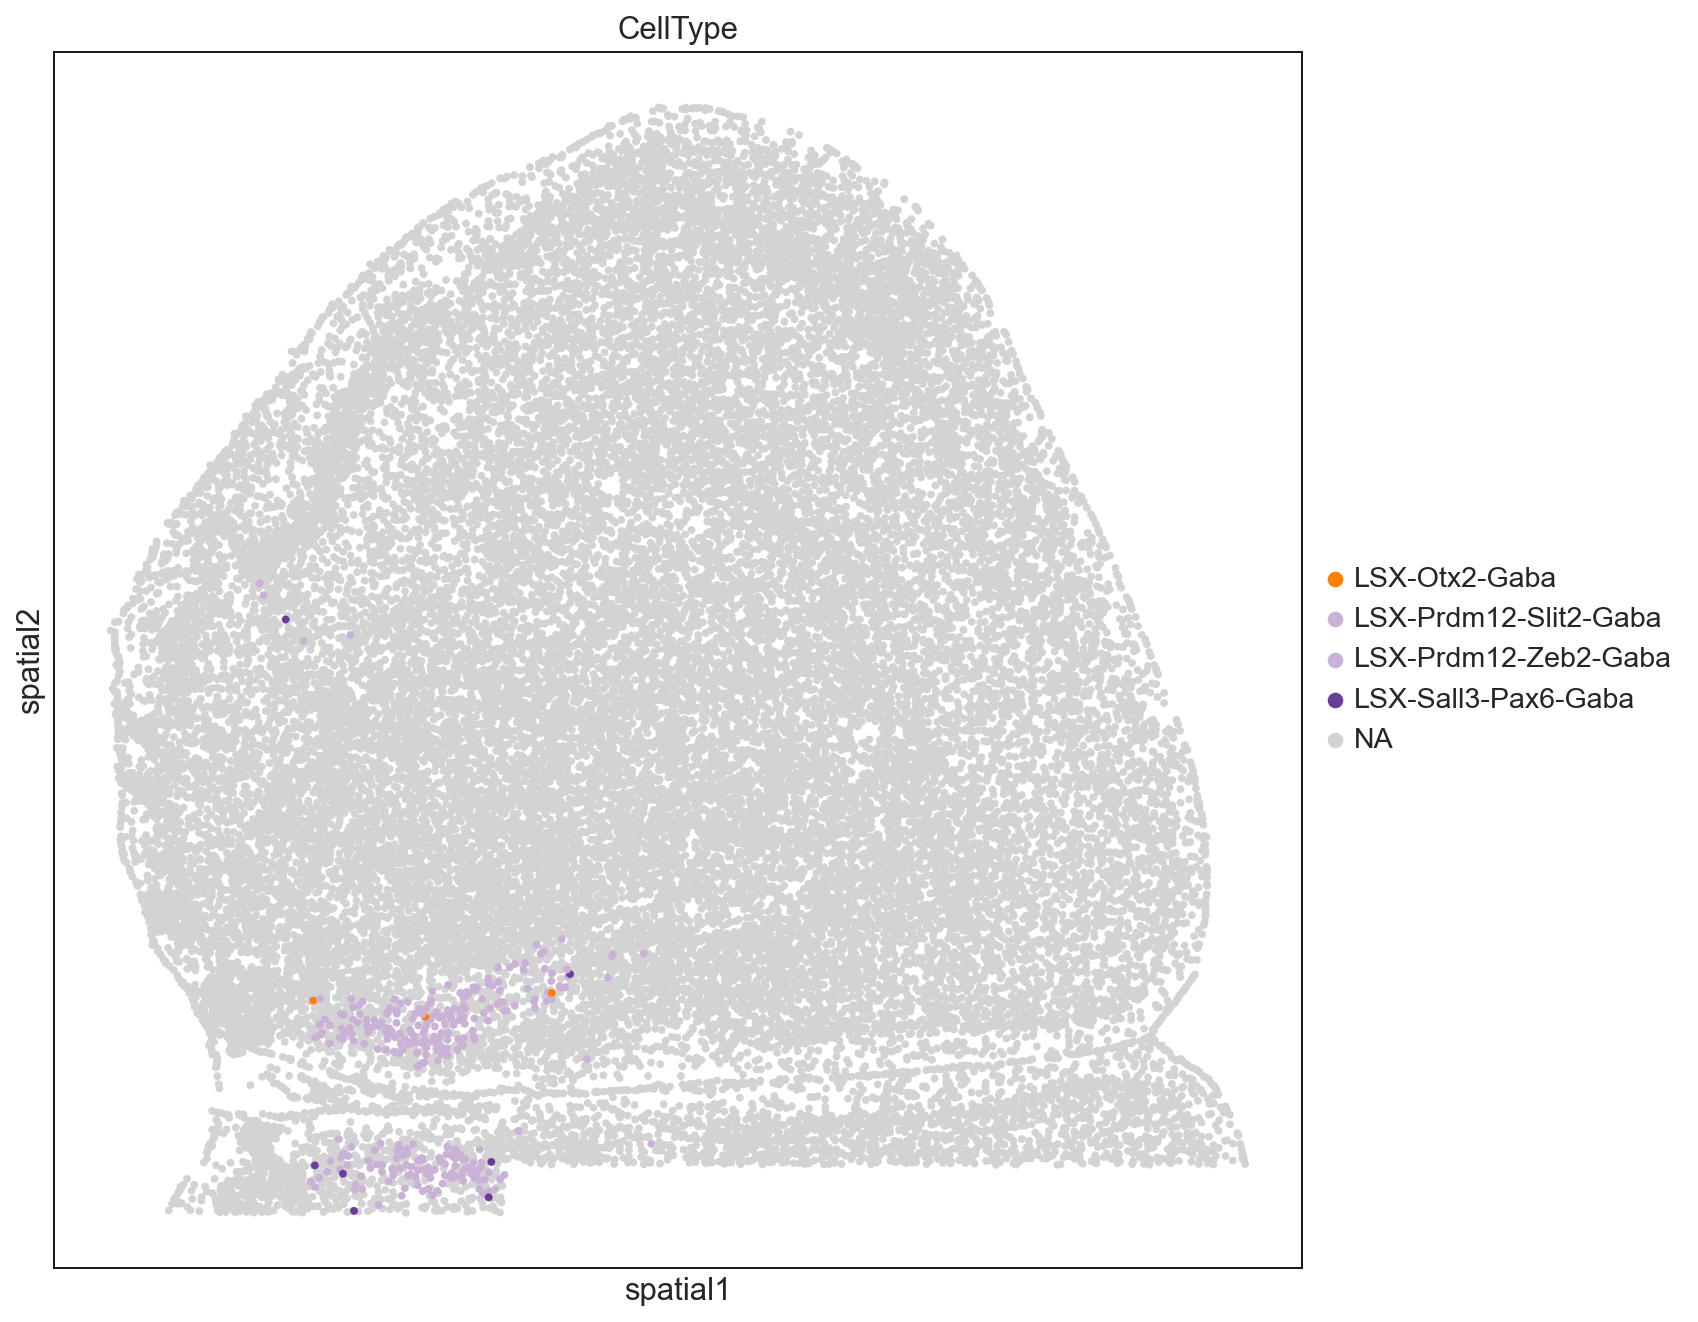

co1_slice23


/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

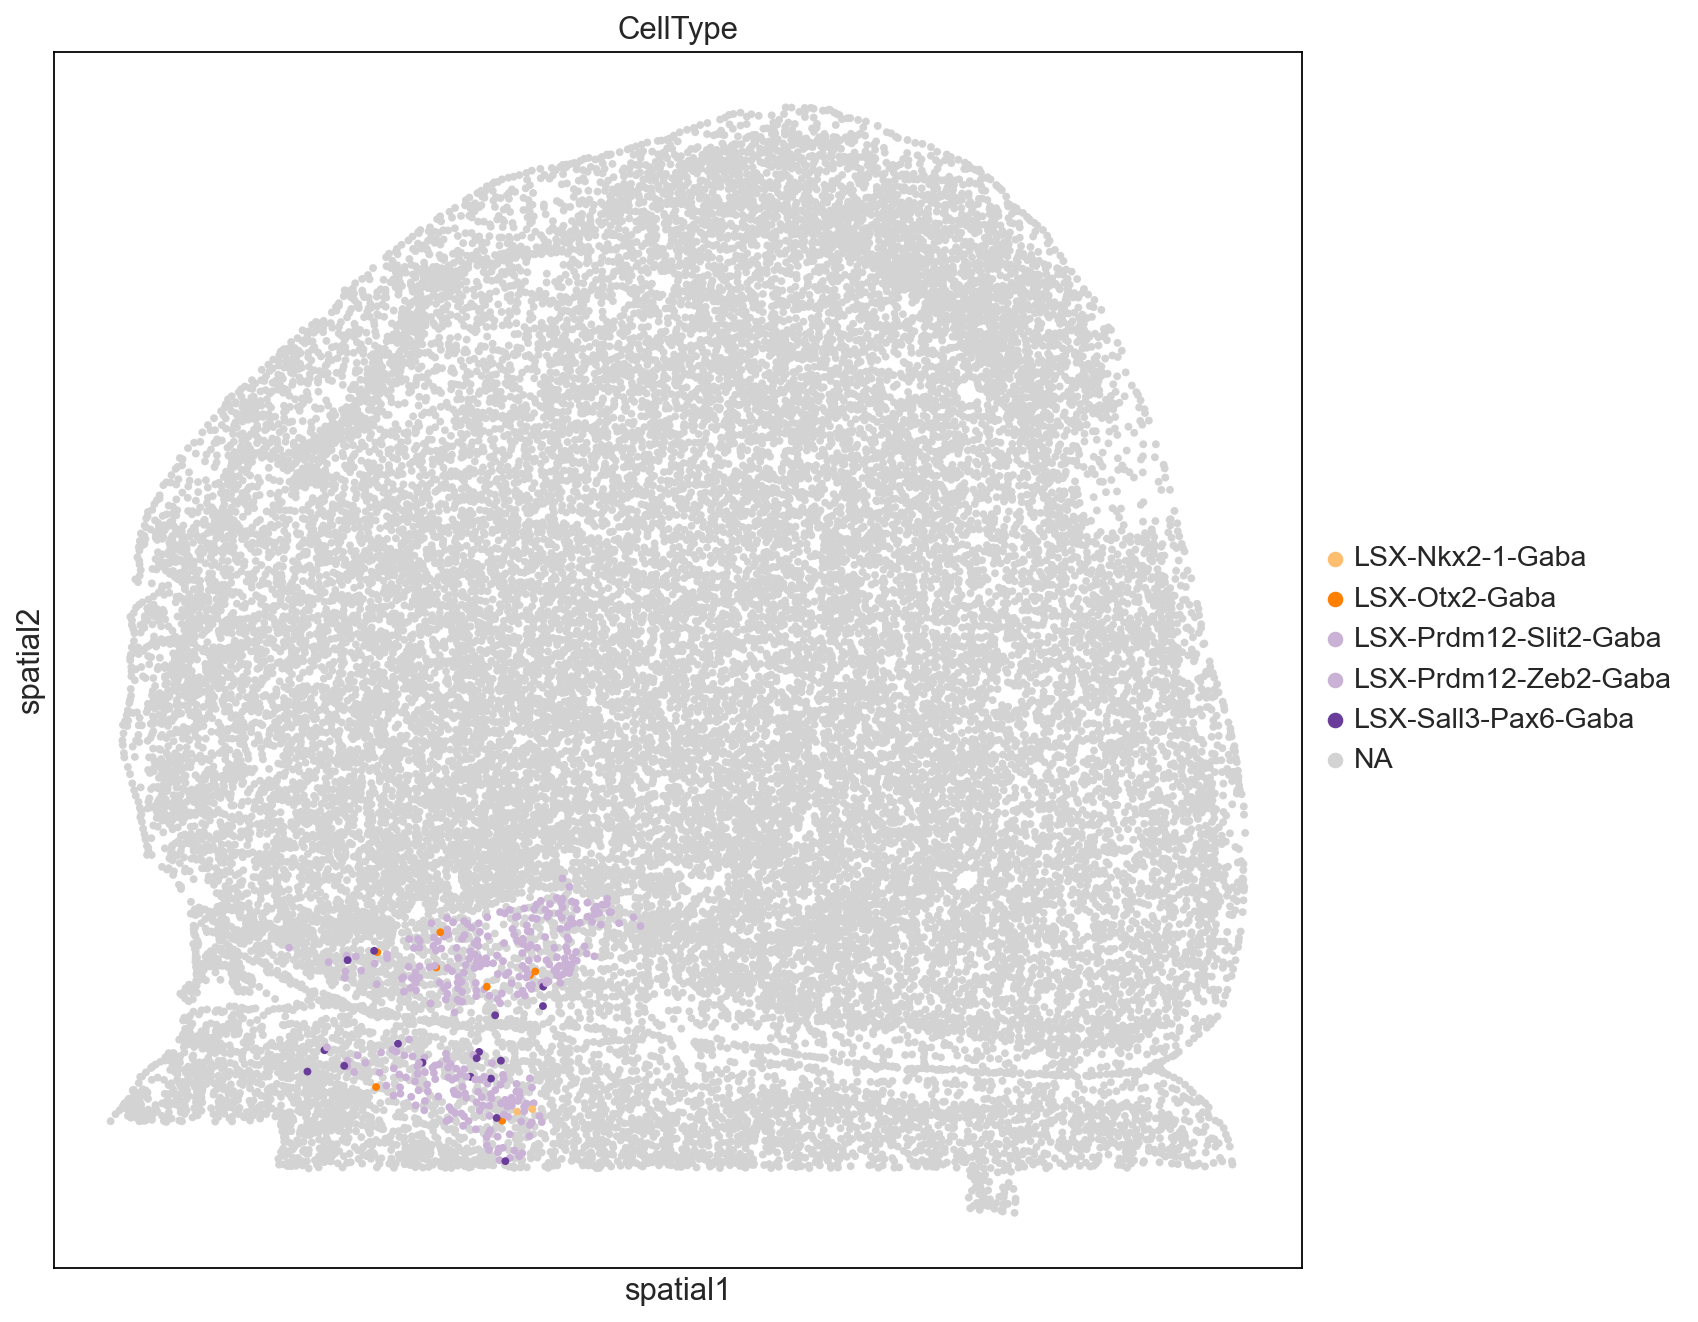

co1_slice25


/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

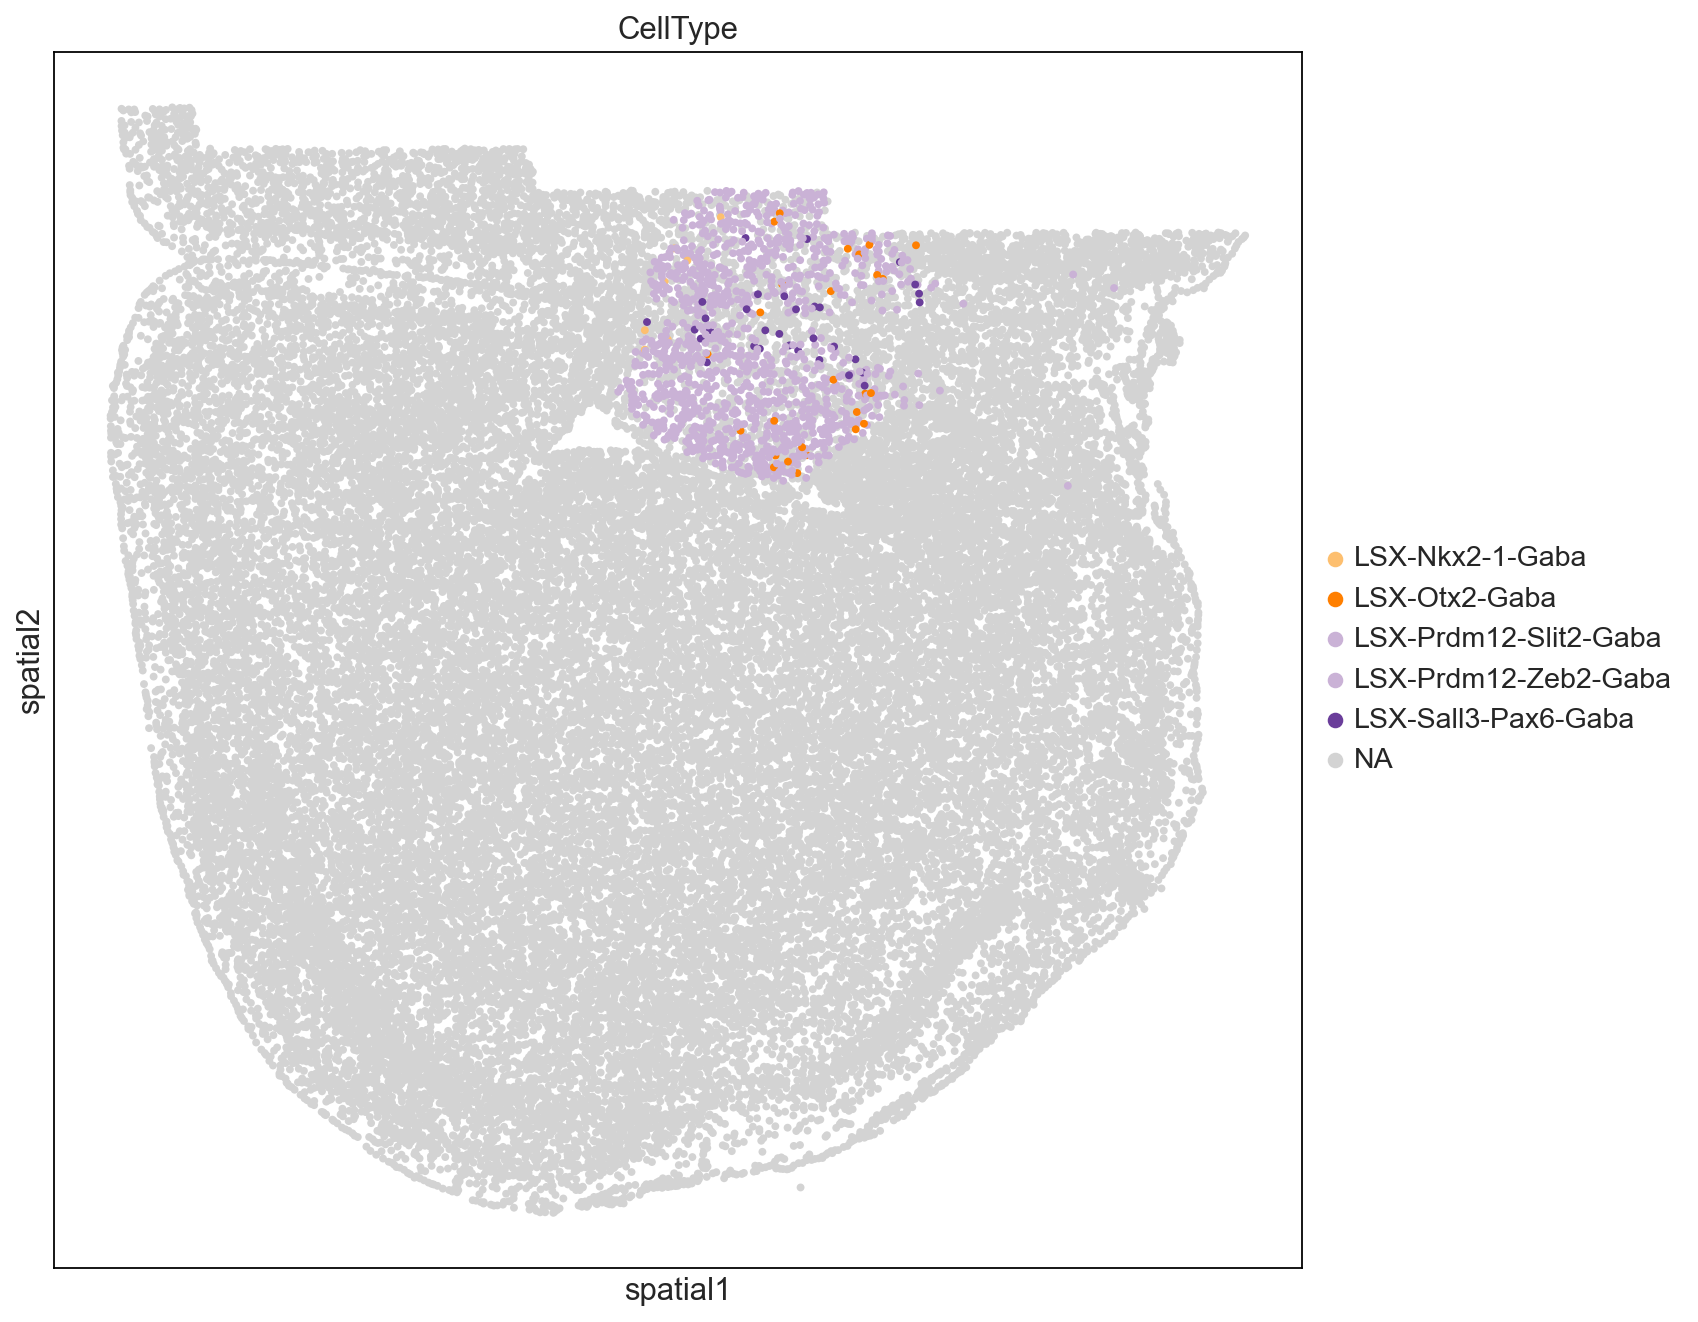

co1_slice26


/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

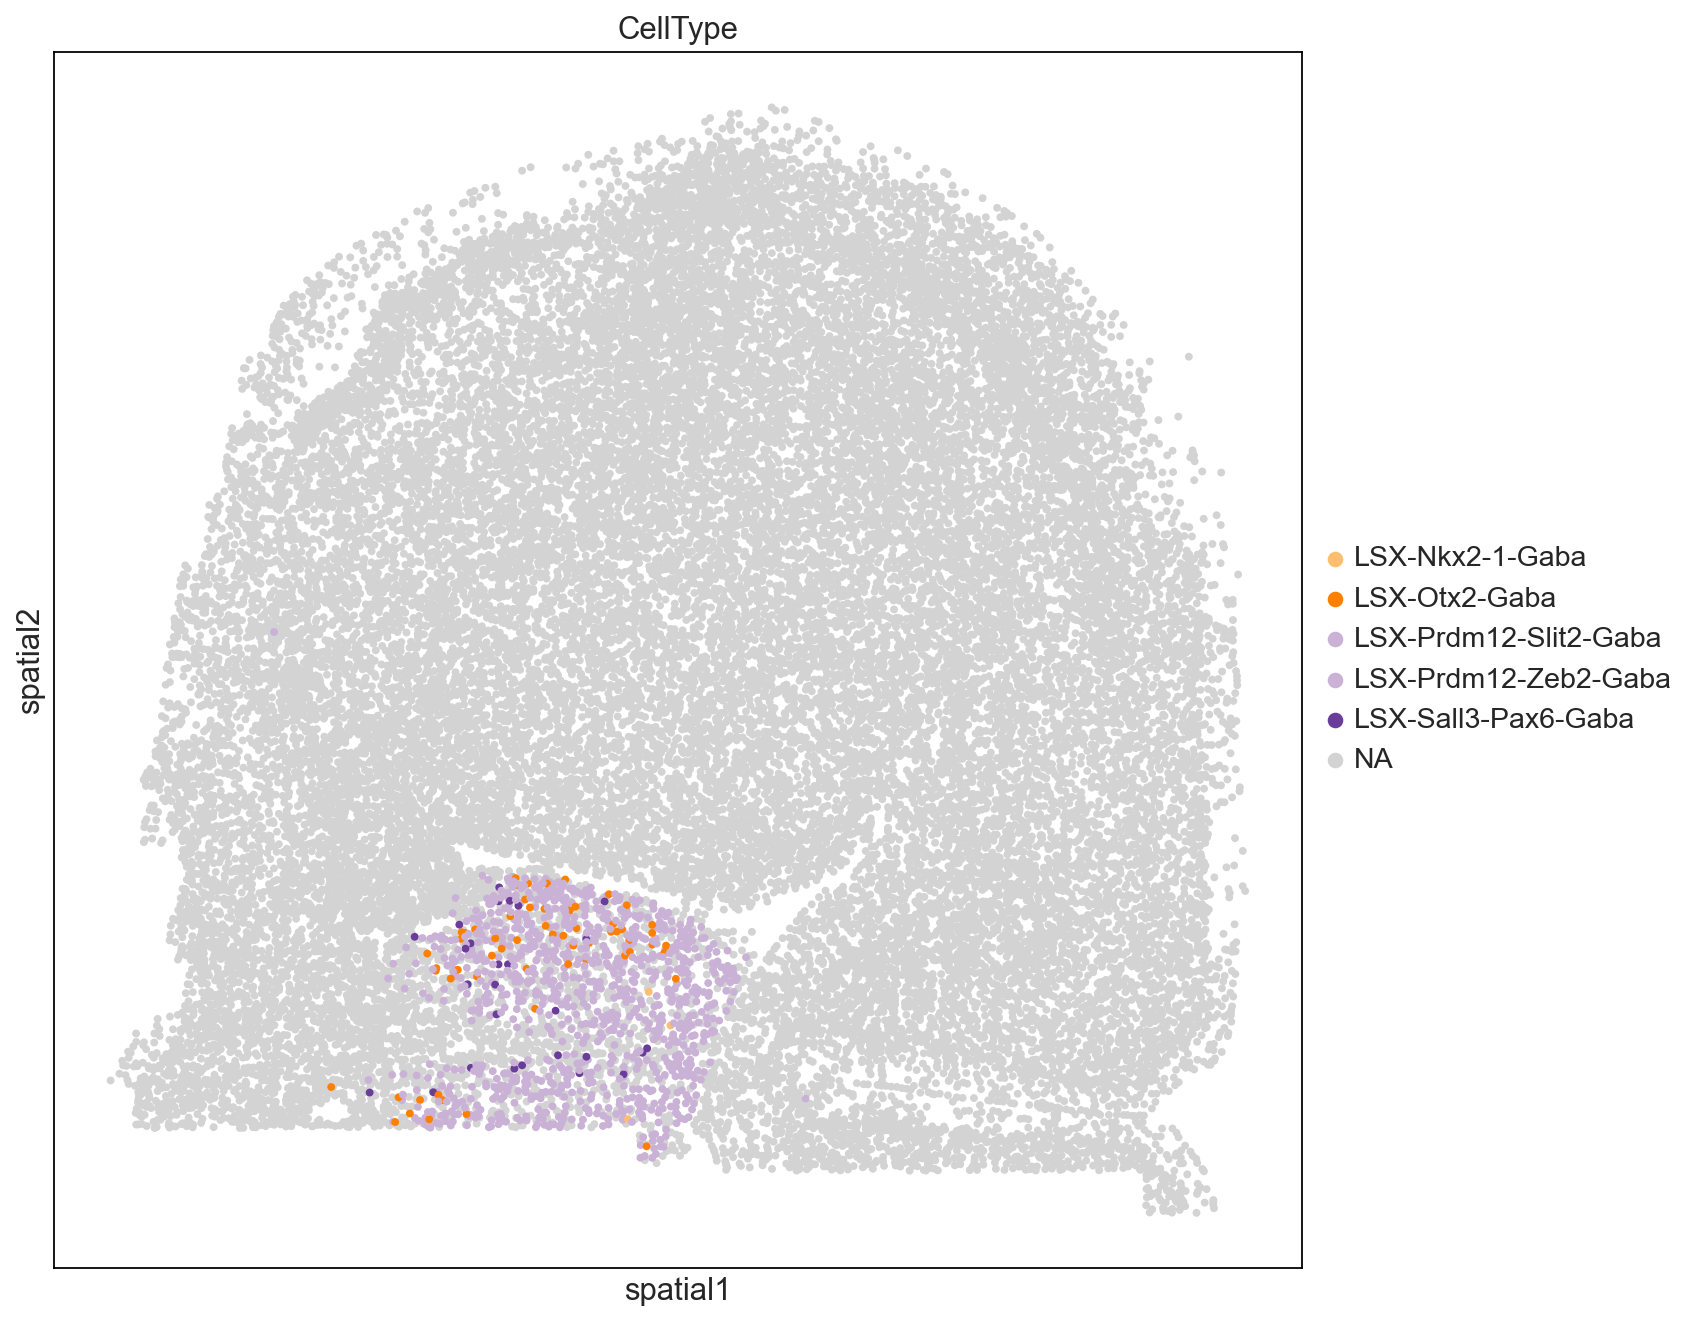

co1_slice27


/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

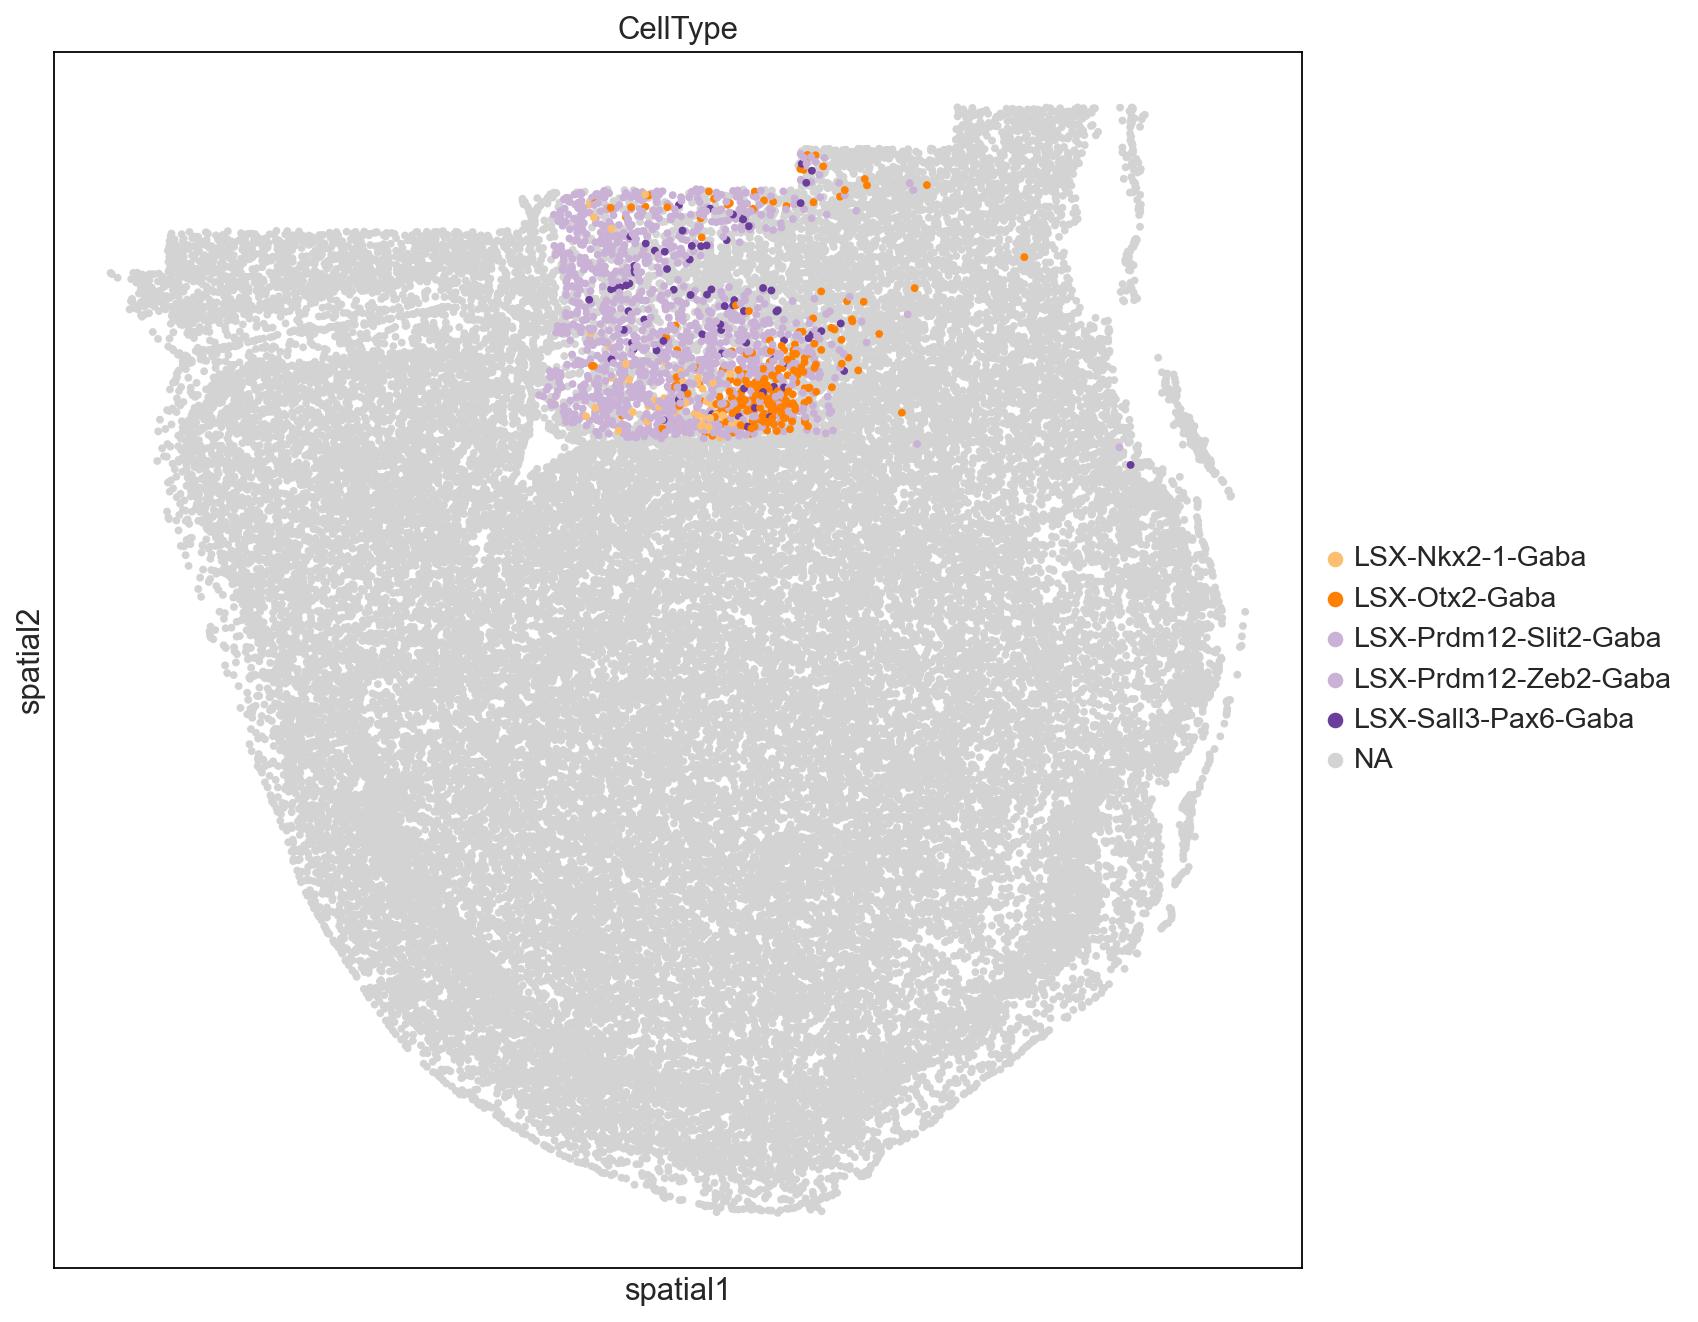

co1_slice28


/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

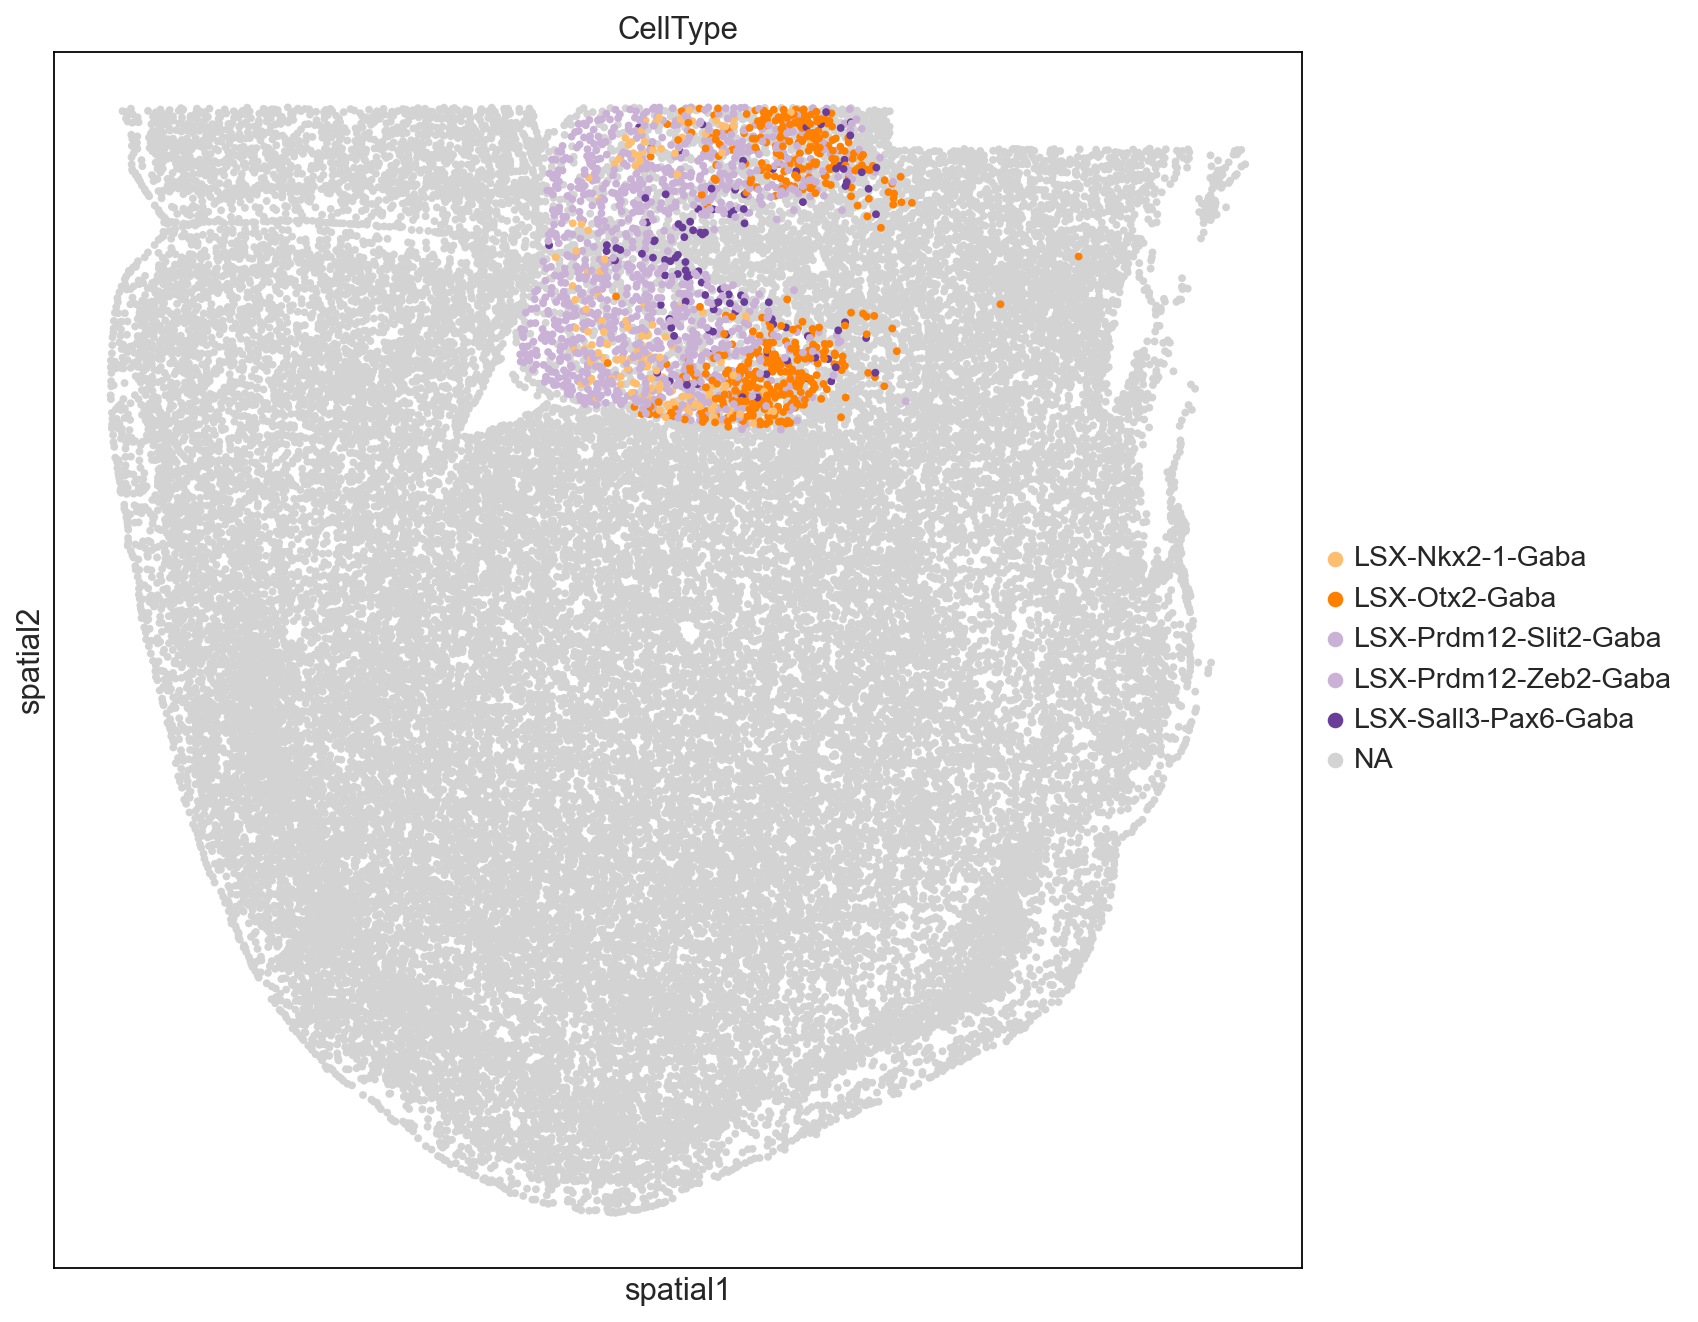

co1_slice30


/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

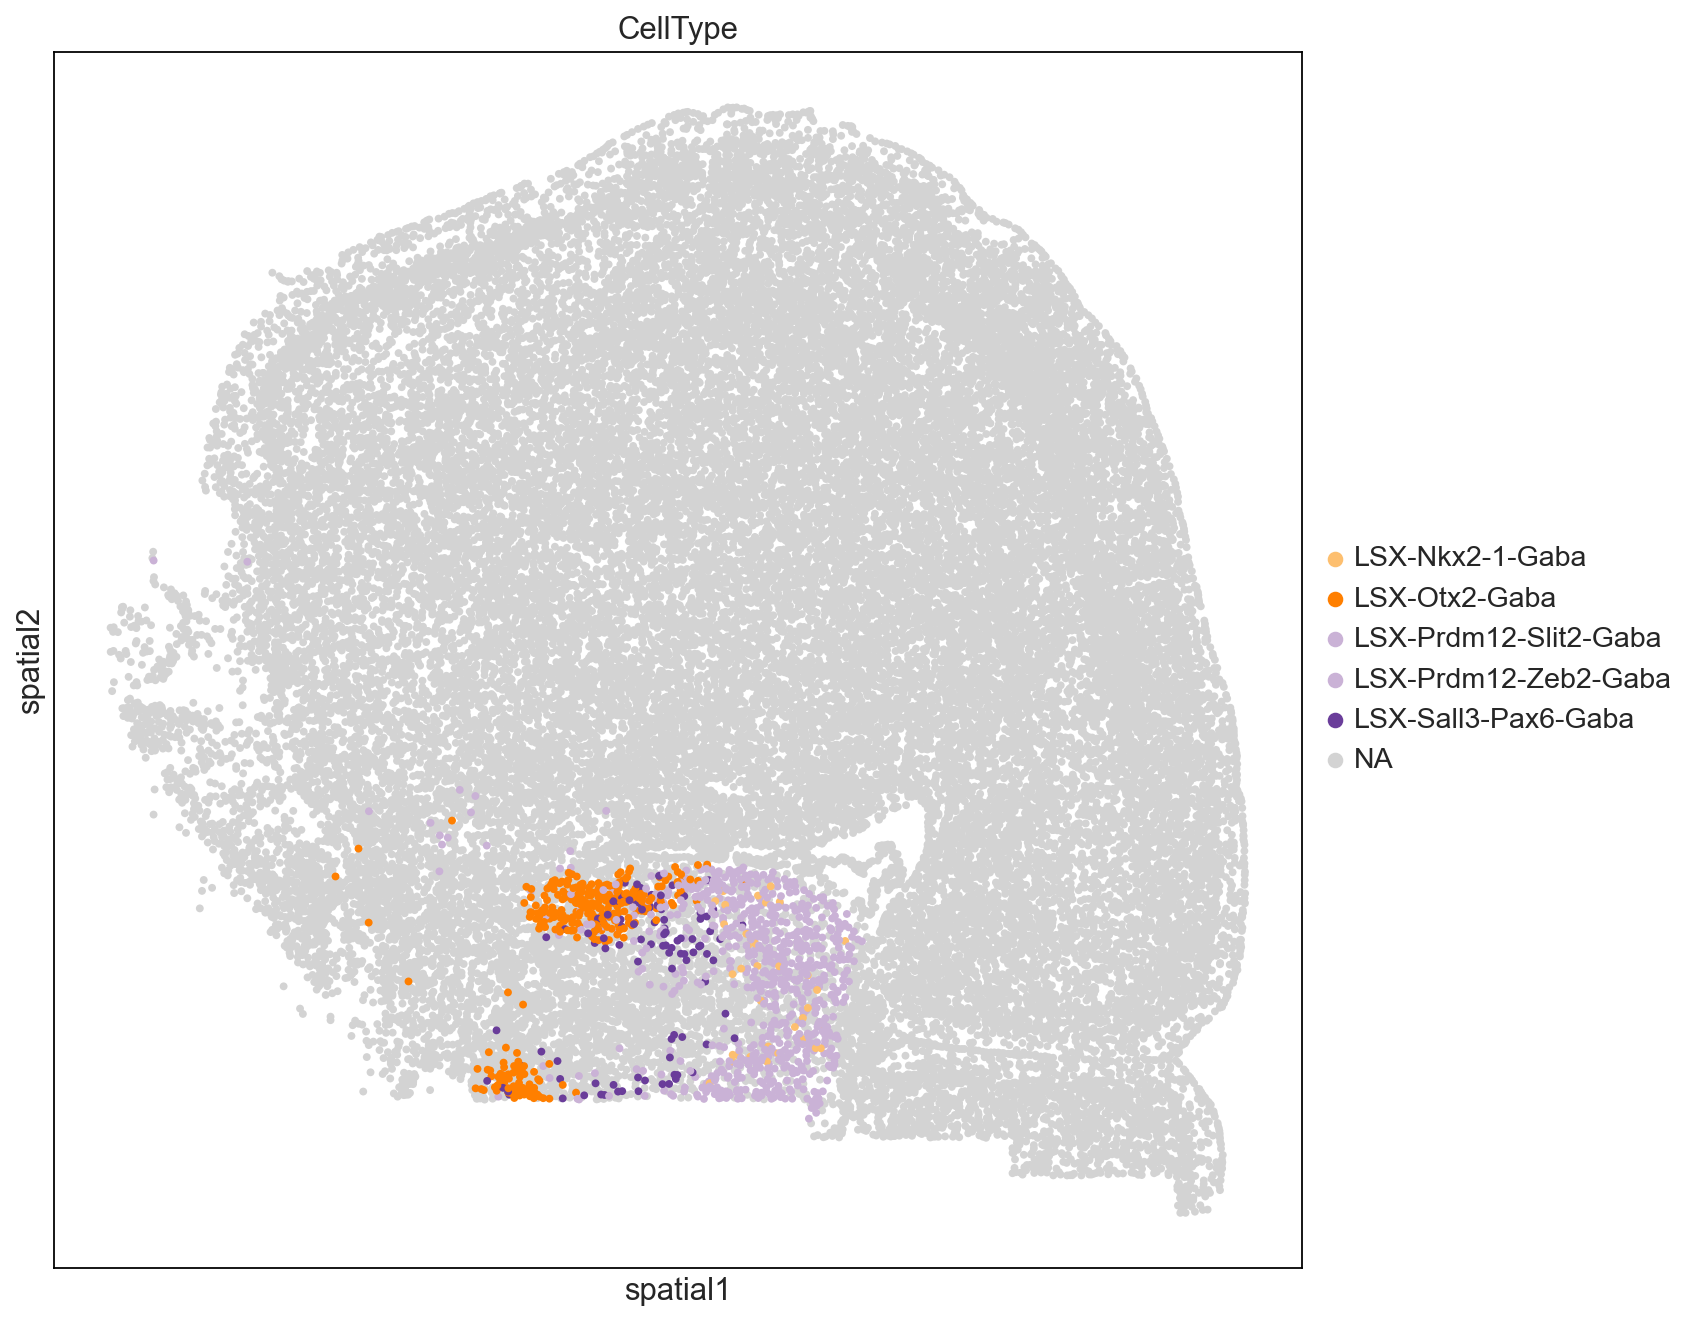

co1_slice31


/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

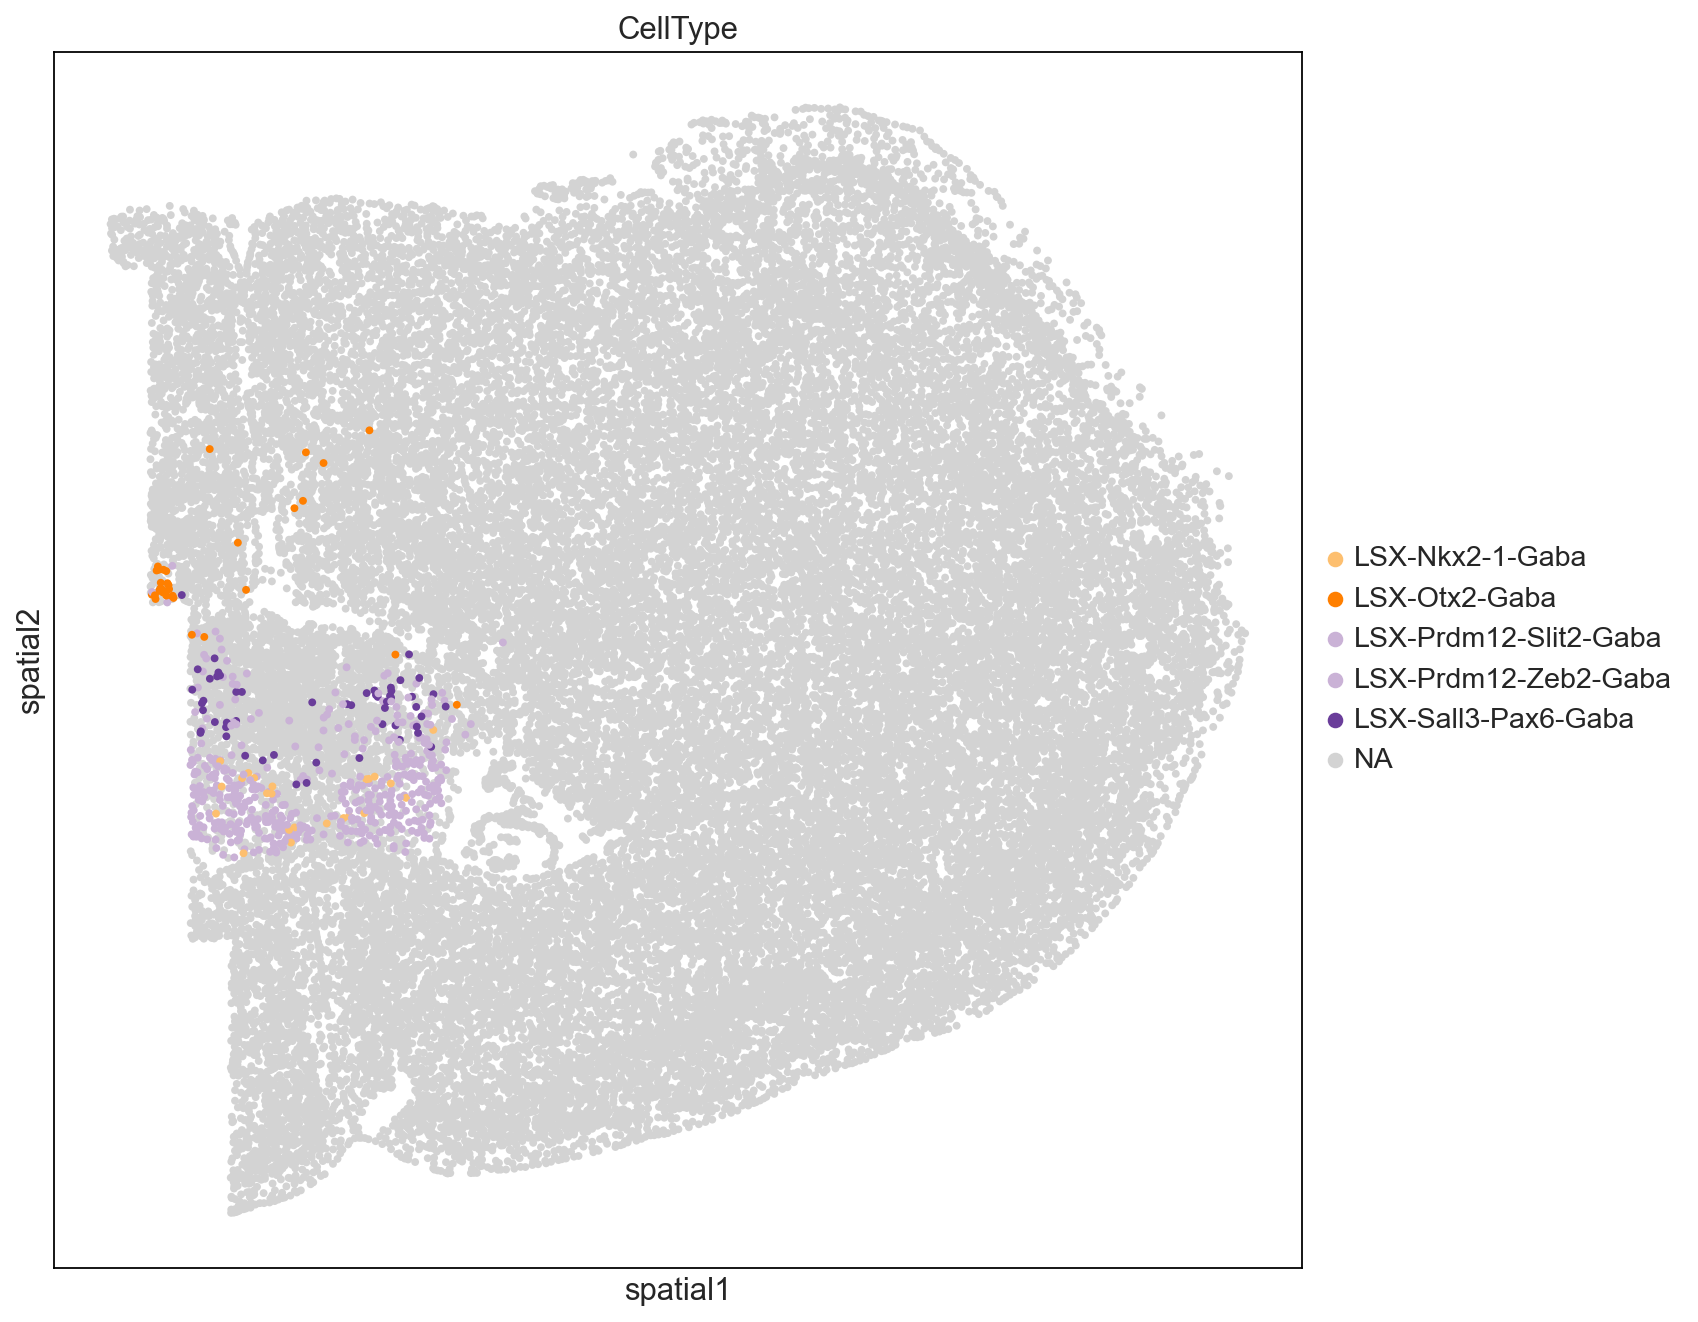

co1_slice32


/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

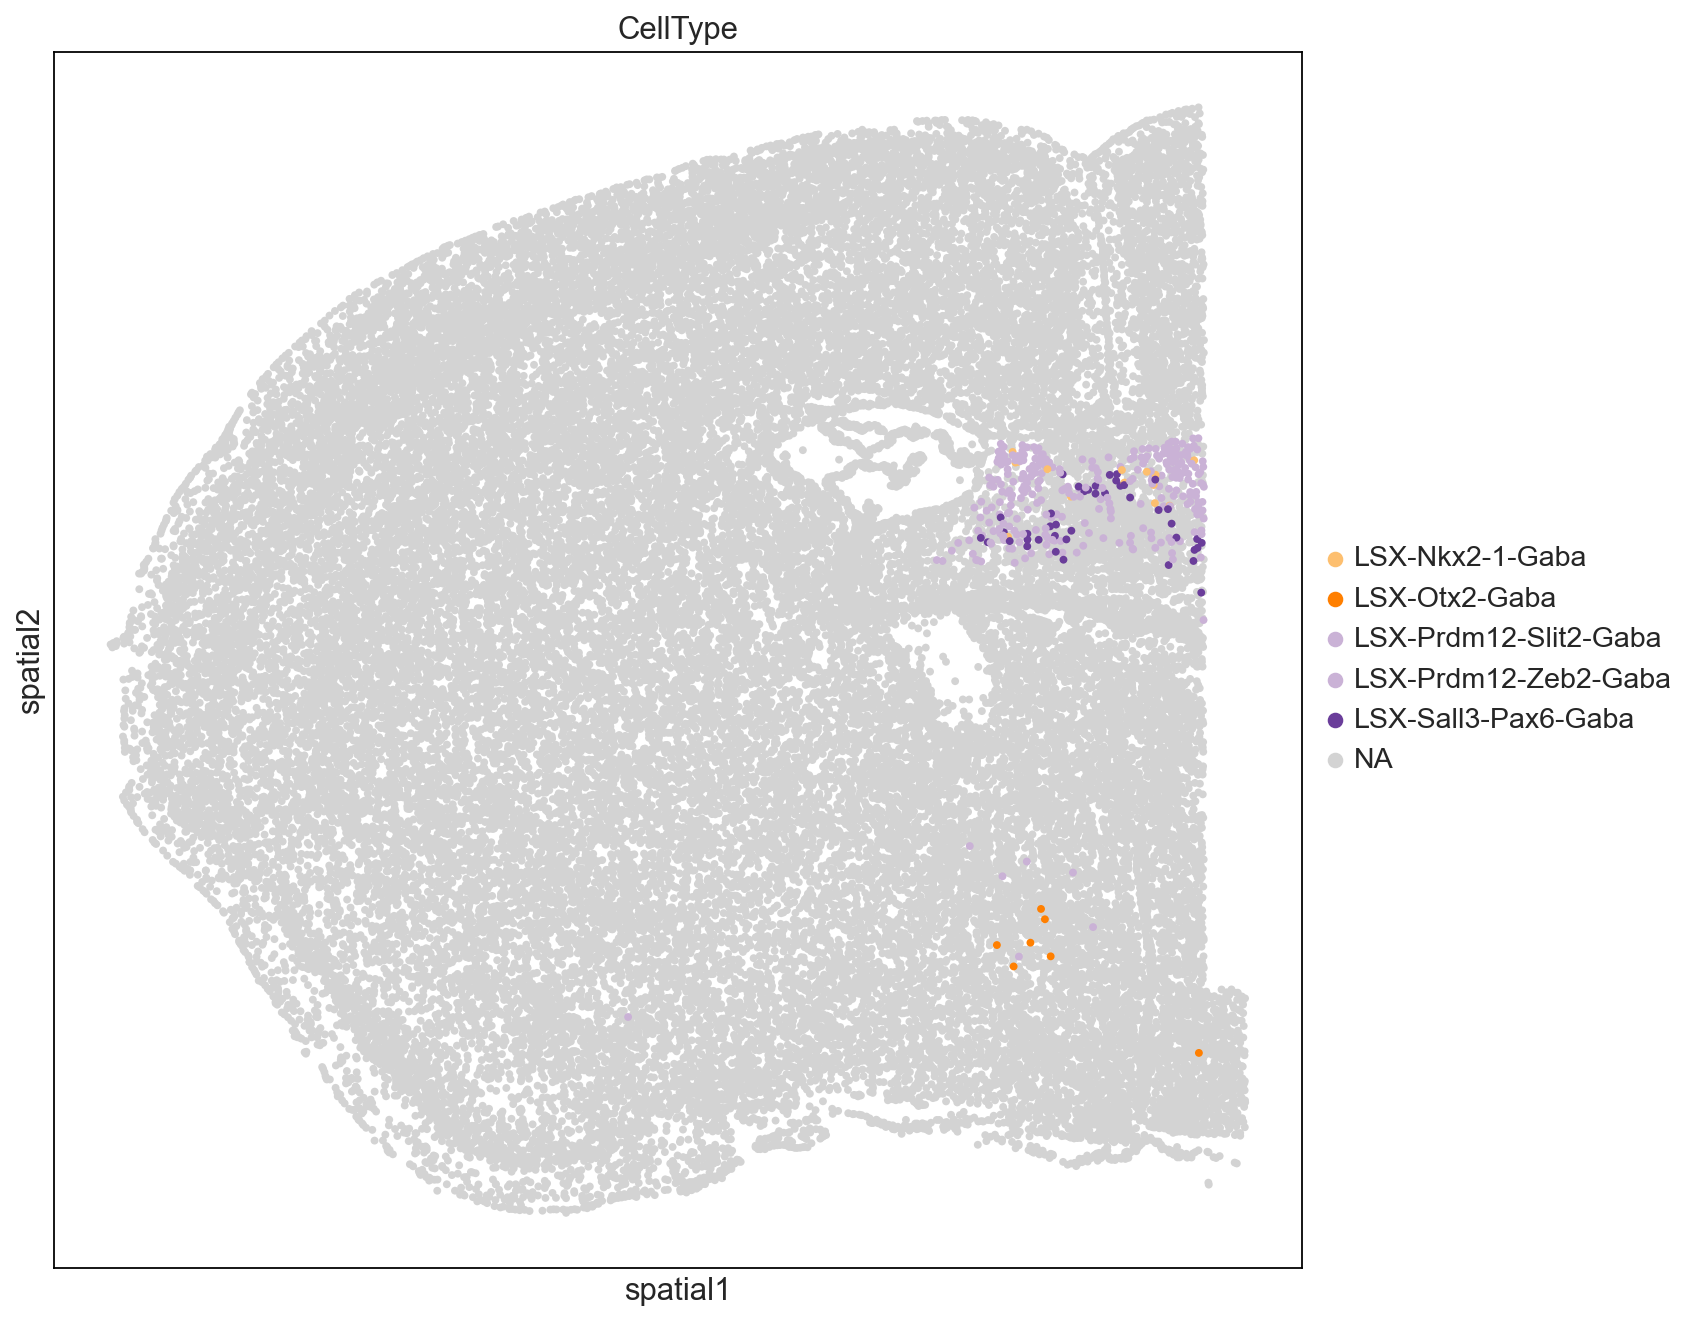

co1_slice33


/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/pax/miniconda3/envs/LS_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3

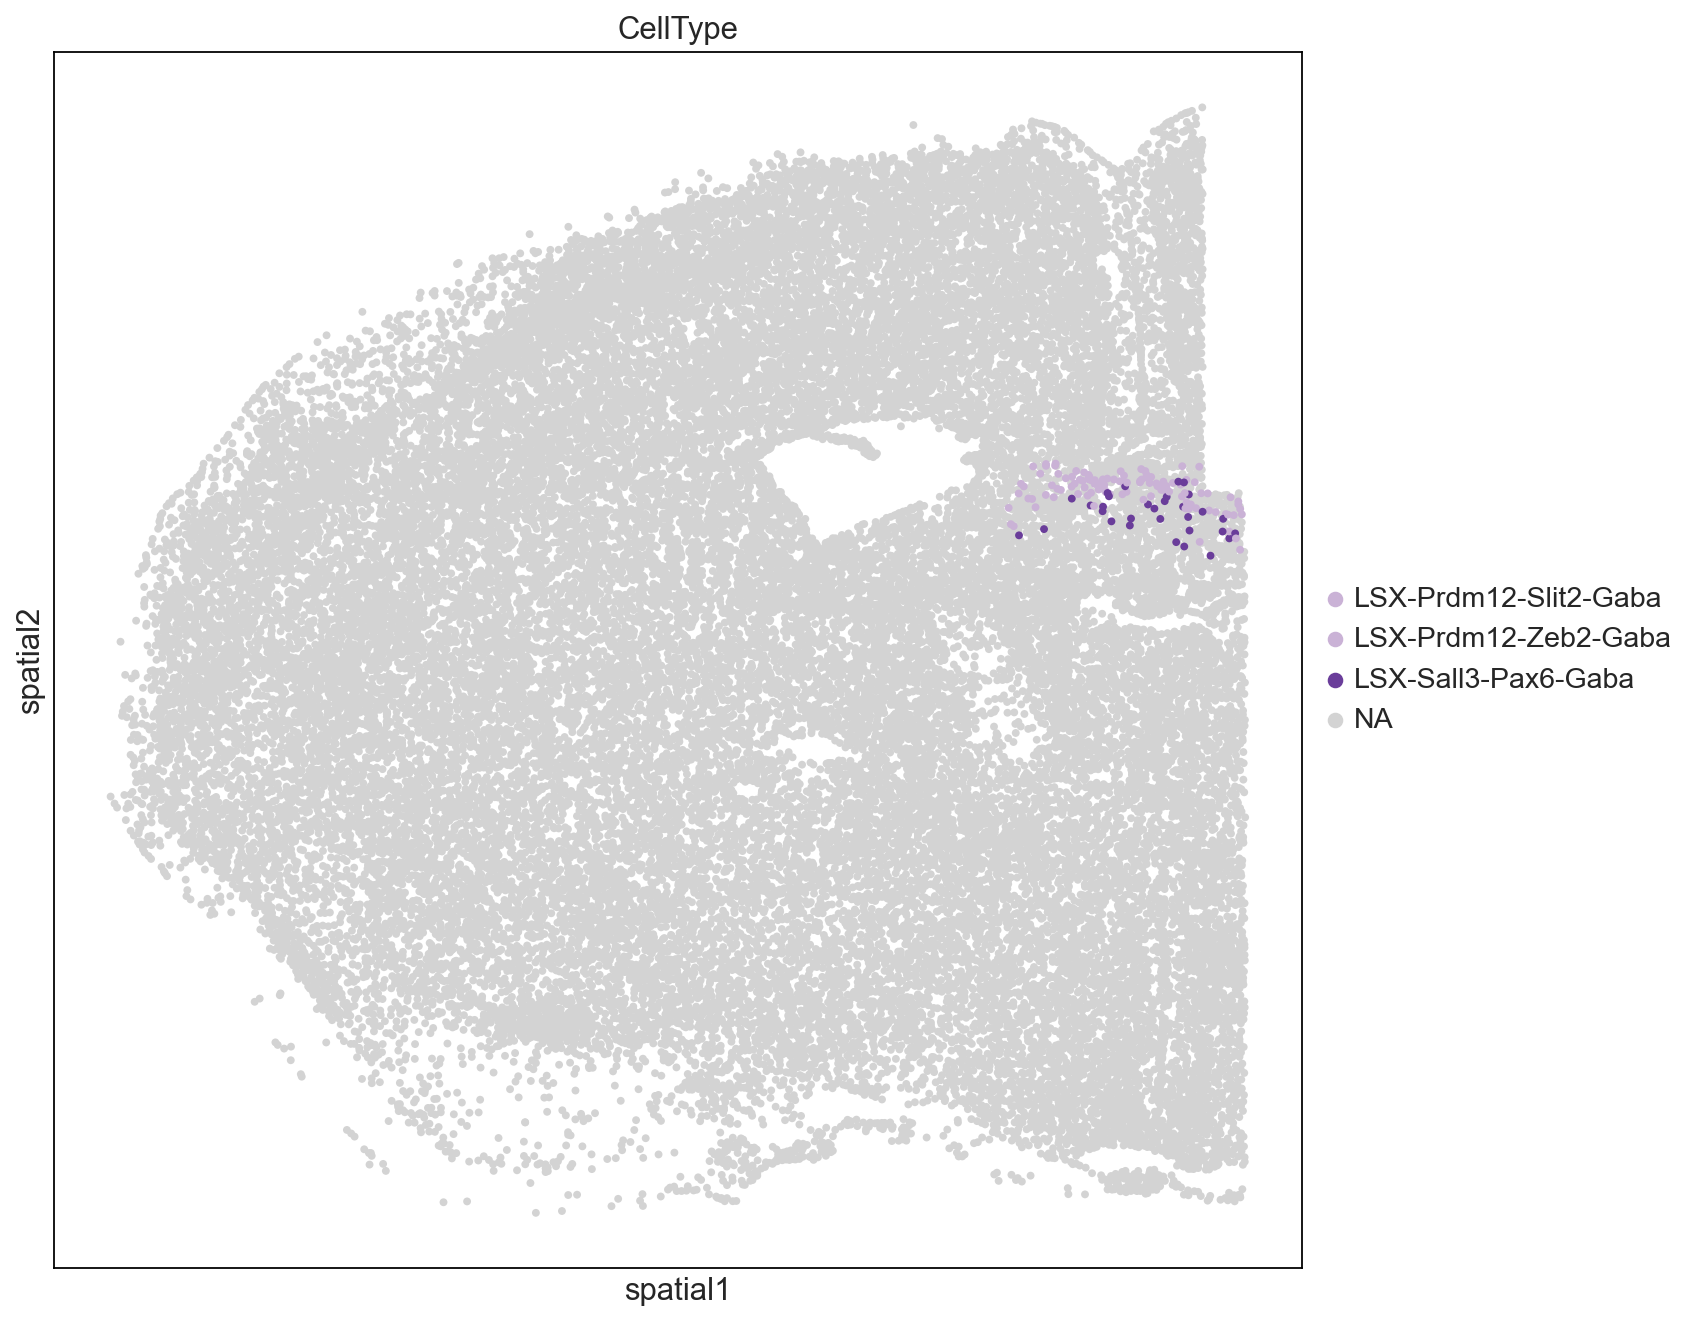

In [167]:
sc.set_figure_params(figsize=(10,10), dpi_save=300)
for id in adata_sp.obs['slice_id'].cat.categories:
    print(id)
    sc.pl.embedding(adata_sp[adata_sp.obs.slice_id == id], basis='spatial', color=['CellType'],
                    groups=lsx_grp, size=50)

In [168]:
# write the MERFISH data
adata_sp.write_h5ad('./Results_h5ad/05_MERFISH_co1_predict.h5ad')